<a href="https://colab.research.google.com/github/ritwiks9635/Sequence_Model_Project/blob/main/Text_Classification_using_Decision_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Text🔡classification using Decision🌳Forests🌳**

In [3]:
!unzip /content/nlp-getting-started.zip

Archive:  /content/nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


```
!pip install tensorflow_decision_forests
```

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras import layers
import tensorflow_decision_forests as tfdf
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv("/content/train.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
df["location"].value_counts()

location
USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: count, Length: 3341, dtype: int64

In [8]:
df.shape

(7613, 5)

In [9]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [10]:
df.drop(["id", "keyword", "location"], axis = 1, inplace = True)
prepare_df = df.sample(frac = 1, random_state = 42).reset_index(drop = True)
print(prepare_df.head())

                                                text  target
0  So you have a new weapon that can cause un-ima...       1
1  The f$&amp;@ing things I do for #GISHWHES Just...       0
2  DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...       1
3  Aftershock back to school kick off was great. ...       0
4  in response to trauma Children of Addicts deve...       0


In [11]:
prepare_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB


In [12]:
prepare_df["target"].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [13]:
for i, data in prepare_df[:5].iterrows():
    print("Ids ::", i)
    print("Text ::", data["text"])
    print("Target ::", data["target"])

Ids :: 0
Text :: So you have a new weapon that can cause un-imaginable destruction.
Target :: 1
Ids :: 1
Text :: The f$&amp;@ing things I do for #GISHWHES Just got soaked in a deluge going for pads and tampons. Thx @mishacollins @/@
Target :: 0
Ids :: 2
Text :: DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe CoL police can catch a pickpocket in Liverpool Stree... http://t.co/vXIn1gOq4Q
Target :: 1
Ids :: 3
Text :: Aftershock back to school kick off was great. I want to thank everyone for making it possible. What a great night.
Target :: 0
Ids :: 4
Text :: in response to trauma Children of Addicts develop a defensive self - one that decreases vulnerability. (3
Target :: 0


In [14]:
test_df = prepare_df.sample(frac = 0.1, random_state = 42)
train_df = prepare_df.drop(test_df.index)

print("Total train data is ::", len(train_df), "Total Test data is ::", len(test_df))

Total train data is :: 6852 Total Test data is :: 761


In [15]:
def build_dataset(df):
    dataset = tf.data.Dataset.from_tensor_slices(
        (df["text"].to_numpy(), df["target"].to_numpy()))
    dataset = dataset.batch(100)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = build_dataset(train_df)
test_dataset = build_dataset(test_df)

###**Downloading pretrained embeddings**

In [16]:
embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4")

In [19]:
# Wrap the embedding_layer in a Keras Layer
class TextEmbeddingLayer(layers.Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.embedding_layer = embedding_layer

  def call(self, inputs):
    return self.embedding_layer(inputs)

# Instantiate the new layer
text_embedding_layer = TextEmbeddingLayer()

# Use the new layer in the model
inputs = layers.Input(shape = (), dtype = tf.string)
outputs = text_embedding_layer(inputs)
preprocessor = keras.Model(inputs, outputs)
model = tfdf.keras.GradientBoostedTreesModel(preprocessing = preprocessor)

Use /tmp/tmp_m4zvy32 as temporary training directory


**They're batch-training models rather than mini-batch gradient descent models, TF-DF models do not need a validation dataset to monitor overfitting, or to stop training early. Some algorithms do not use a validation dataset (e.g. Random Forest) while some others do (e.g. Gradient Boosted Trees). If a validation dataset is needed, it will be extracted automatically from the training dataset.**

In [21]:
model.compile(metrics=["Accuracy", "Recall", "Precision", "AUC"])
# Here we do not specify epochs as, TF-DF trains exactly one epoch of the dataset
model.fit(train_dataset)

Reading training dataset...
Training dataset read in 0:00:21.963629. Found 6852 examples.
Training model...
Model trained in 0:02:45.084660
Compiling model...
Model compiled.


In [26]:
print("model summary: ")
print(model.summary())

model summary: 
Model: "gradient_boosted_trees_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (512):
	functional_1_1/text_embedding_layer_1/keras_layer/StatefulPartitionedCall:0.0
	functional_1_1/text_embedding_layer_1/keras_layer/StatefulPartitionedCall:0.1
	functional_1_1/text_embedding_layer_1/keras_layer/StatefulPartitionedCall:0.10
	functional_1_1/text_embedding_layer_1/keras_layer/StatefulPartitionedCall:0.100
	functional_1_1/text_embedding_layer_1/keras_layer/StatefulPartitionedCall:0.101
	functional_1_1/text_embedding_layer_1/keras_layer/StatefulPartitionedCall:0.102
	functional_1_1/text_embedding_layer_1/keras_layer/StatefulPartitionedCall:0.10

In [22]:
logs = model.make_inspector().training_logs()
print(logs)

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=None, accuracy=0.5656716227531433, loss=1.3077609539031982, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=2, evaluation=Evaluation(num_examples=None, accuracy=0.6865671873092651, loss=1.2614209651947021, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=3, evaluation=Evaluation(num_examples=None, accuracy=0.7417910695075989, loss=1.2177786827087402, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=4, evaluation=Evaluation(num_examples=None, accuracy=0.7701492309570312, loss=1.1783922910690308, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=5, evaluation=Evaluation(num_examples=None, accuracy=0.7776119112968445, loss=1.1459333896636963, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=6, evaluation=Evaluation(num_examples=None, accuracy=0.7835820913314819, loss=1.1136521100997925, rmse=None, n

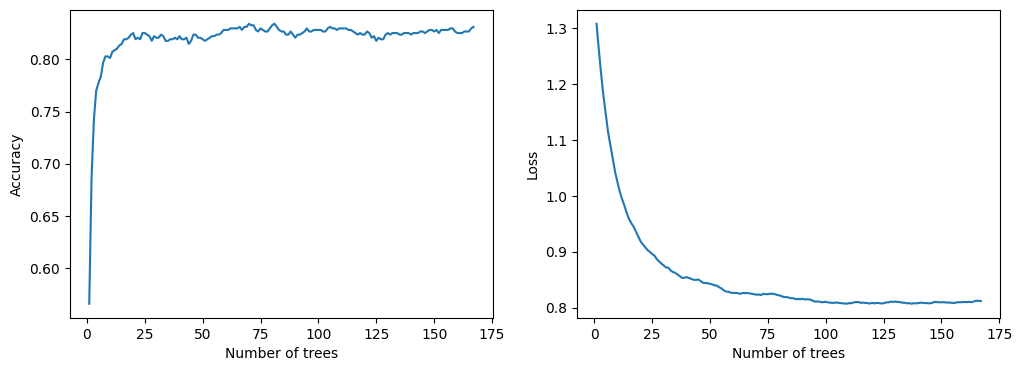

In [23]:
def plot_curve(logs):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Loss")

    plt.show()


plot_curve(logs)

In [27]:
results = model.evaluate(test_dataset, return_dict=True, verbose=0)
print("model Evaluation: \n")
for name, value in results.items():
    print(f"{name}: {value:.4f}")

model Evaluation: 

loss: 0.0000
Accuracy: 0.8160
recall: 0.7241
precision: 0.8514
auc: 0.8700


In [28]:
test_df.reset_index(inplace=True, drop=True)
for index, row in test_df.iterrows():
    text = tf.expand_dims(row["text"], axis=0)
    preds = model.predict_step(text)
    preds = tf.squeeze(tf.round(preds))
    print(f"Text: {row['text']}")
    print(f"Prediction: {int(preds)}")
    print(f"Ground Truth : {row['target']}")
    if index == 10:
        break

Text: DFR EP016 Monthly Meltdown - On Dnbheaven 2015.08.06 http://t.co/EjKRf8N8A8 #Drum and Bass #heavy #nasty http://t.co/SPHWE6wFI5
Prediction: 0
Ground Truth : 0
Text: FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday
Prediction: 1
Ground Truth : 0
Text: Gunmen kill four in El Salvador bus attack: Suspected Salvadoran gang members killed four people and wounded s... http://t.co/CNtwB6ScZj
Prediction: 1
Ground Truth : 1
Text: @camilacabello97 Internally and externally screaming
Prediction: 0
Ground Truth : 1
Text: Radiation emergency #preparedness starts with knowing to: get inside stay inside and stay tuned http://t.co/RFFPqBAz2F via @CDCgov
Prediction: 1
Ground Truth : 1
Text: Investigators rule catastrophic structural failure resulted in 2014 Virg.. Related Articles: http://t.co/Cy1LFeNyV8
Prediction: 1
Ground Truth : 1
Text: How the West was burned: Thousands of wildfires ablaze in #California alone http://t.co/iCSjGZ